In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5MB 3.9MB/s 
     |████████████████████████████████| 901kB 15.7MB/s 
     |████████████████████████████████| 3.3MB 18.8MB/s 


In [ ]:
import numpy as np
import pandas as pd
import torch
import transformers as tfm 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

In [ ]:
from IPython.display import display, HTML

In [ ]:
display(HTML(df.head(5).to_html()))

,0,1
0,"a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films",1
1,apparently reassembled from the cutting room floor of any given daytime soap,0
2,"they presume their audience wo n't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science fiction elements of bug eyed monsters and futuristic women in skimpy clothes",0
3,"this is a visually stunning rumination on love , memory , history and the war between art and commerce",1
4,jonathan parker 's bartleby should have been the be all end all of the modern office anomie films,1


### 1) Distilbert embed + downstream model

In [ ]:
model_cls, tokenizer_cls, pretrained_weights = (tfm.DistilBertModel, tfm.DistilBertTokenizer, 'distilbert-base-uncased')

#gpt2-medium, xlnet-base-cased, distilroberta-base
# Load pretrained model/tokenizer
tokenizer = tokenizer_cls.from_pretrained(pretrained_weights)
base = model_cls.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
partial_df = df[:2000]

In [ ]:
# tokenize our data

tokenized = partial_df[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True))) #df[0] for text data
#tokenized = df[0].apply((lambda x: tokenizer(x, add_special_tokens=True, padding=True, truncation=True))) #df[0] for text data #this will need further processing to take out the inputs

In [ ]:
max_len = max(tokenized.apply(len))
# for i,_ in enumerate(tokenized):
#   tokenized[i] = _ + [0] * (max_len - len(_))
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
sum(tokenized.apply(len) != max_len) #should be 0

1998

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2000, 59)

In [ ]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = base(input_ids, attention_mask=attention_mask)

NameError: ignored

#### Obtain features

Let's slice only the part of the output that we need. That is the output corresponding the first token of each sentence. The way BERT does sentence classification, is that it adds a token called `[CLS]` (for classification) at the beginning of every sentence. The output corresponding to that token can be thought of as an embedding for the entire sentence.

<img src="https://jalammar.github.io/images/distilBERT/bert-output-tensor-selection.png" />

We'll save those in the `features` variable, as they'll serve as the features to our logitics regression model.

In [ ]:
features = last_hidden_states[0][:,0,:].numpy() # 1st column as data

In [ ]:
labels = partial_df[1]

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

#### Logistic Regression

In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lr_clf.score(test_features, test_labels)

0.842

In [ ]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.513 (+/- 0.06)


/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
parameters = {'C': np.linspace(0.0001, 100, 20)}
grid_search = GridSearchCV(LogisticRegression(), parameters)
grid_search.fit(train_features, train_labels)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


best parameters:  {'C': 5.263252631578947}
best scrores:  0.82


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### Keras net

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout

In [ ]:
model = Sequential()
model.add(Dense(12, input_dim=train_features.shape[-1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
train_features

array([[ 0.05518246,  0.05218065, -0.19472224, ..., -0.0466518 ,
         0.3339935 ,  0.33965135],
       [-0.23889747, -0.02429577, -0.08579729, ..., -0.14099516,
         0.46552664,  0.4204045 ],
       [-0.18533218,  0.17603475,  0.01273761, ..., -0.03043812,
         0.38508368,  0.4188455 ],
       ...,
       [ 0.0287509 , -0.07249206, -0.00997563, ..., -0.16726762,
         0.3817531 ,  0.14303145],
       [ 0.05947765,  0.00360898, -0.15821084, ..., -0.17831315,
         0.46216553,  0.1365274 ],
       [-0.37515914, -0.07685902, -0.33980823, ..., -0.22525652,
         0.39745924,  0.25472748]], dtype=float32)

In [ ]:
model.fit(train_features, train_labels , epochs=150, batch_size=1000)

Epoch 1/150
2/2 [==============================] - 14s 6ms/step - loss: 0.8397 - accuracy: 0.4881
Epoch 2/150
2/2 [==============================] - 0s 5ms/step - loss: 0.7880 - accuracy: 0.5213
Epoch 3/150
2/2 [==============================] - 0s 5ms/step - loss: 0.7340 - accuracy: 0.5624
Epoch 4/150
2/2 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.6067
Epoch 5/150
2/2 [==============================] - 0s 4ms/step - loss: 0.6515 - accuracy: 0.6219
Epoch 6/150
2/2 [==============================] - 0s 4ms/step - loss: 0.6317 - accuracy: 0.6282
Epoch 7/150
2/2 [==============================] - 0s 5ms/step - loss: 0.6168 - accuracy: 0.6522
Epoch 8/150
2/2 [==============================] - 0s 5ms/step - loss: 0.6066 - accuracy: 0.6693
Epoch 9/150
2/2 [==============================] - 0s 5ms/step - loss: 0.5833 - accuracy: 0.6888
Epoch 10/150
2/2 [==============================] - 0s 5ms/step - loss: 0.5714 - accuracy: 0.6873
Epoch 11/150
2/2 [==========

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

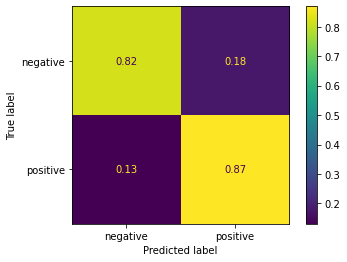

In [ ]:
#predictions = np.round(model.predict(test_features)).astype(int)
predictions = model.predict(test_features)
predictions = np.where(predictions > 0.5, 1, 0) #np.round(model.predict(features)).astype(int)
cf_mat = confusion_matrix(test_labels, predictions, normalize = 'true')
cf_plot = ConfusionMatrixDisplay(cf_mat, display_labels= ["negative", "positive"])
cf_plot.plot()

In [ ]:
print(classification_report(test_labels, predictions, target_names = ["negative", "positive"]))

              precision    recall  f1-score   support

    negative       0.79      0.93      0.85       240
    positive       0.92      0.78      0.84       260

    accuracy                           0.85       500
   macro avg       0.86      0.85      0.85       500
weighted avg       0.86      0.85      0.85       500



In [ ]:
def pred_sentence(sentence):
  if len(sentence) > max_len:
    print(f"input length exceed model original dimension. Input truncated to {max_len} long")
    sentence = sentence[:max_len]

  tokenized = tokenizer.encode(sentence, add_special_tokens=True)
  padded = tokenized + [0] * (max_len - len(tokenized))
  padded = np.array([padded])
  attention_mask = np.where(padded != 0, 1, 0)
  input_ids = torch.tensor(padded)  
  attention_mask = torch.tensor(attention_mask)
  with torch.no_grad():
      last_hidden_states = base(input_ids, attention_mask=attention_mask)
      features = last_hidden_states[0][:,0,:].numpy() # 1st column as data

  prediction = model.predict(features)
  prediction = np.where(prediction > 0.5, 1, 0) #np.round(model.predict(features)).astype(int)
  result = np.where(prediction, "positive", "negative")[0]
  return result

In [ ]:
def pred_sentences(sentences):
  for i,sentence in enumerate(sentences):
    if len(sentence) > max_len:
      print(f"input length exceed model original dimension. Input truncated to {max_len} long")
      sentences[i] = sentence[:max_len]
  sentences = pd.Series(sentences)
  tokenized = pd.Series(sentences).apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
  padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
  attention_mask = np.where(padded != 0, 1, 0)
  input_ids = torch.tensor(padded)  
  attention_mask = torch.tensor(attention_mask)
  with torch.no_grad():
      last_hidden_states = base(input_ids, attention_mask=attention_mask)
      features = last_hidden_states[0][:,0,:].numpy() # 1st column as data

  prediction = model.predict(features)
  prediction = np.where(prediction > 0.5, 1, 0) #np.round(model.predict(features)).astype(int)
  result = np.where(prediction, "positive", "negative")
  return result

In [ ]:
df[2000:2010][0].values.tolist()

['two tedious acts light on great scares and a good surprise ',
 'and your reward will be a thoughtful , emotional movie expe',
 'obvious',
 "`` birthday girl '' is an actor 's movie first and foremost",
 "the little girls understand , and mccracken knows that 's a",
 'the pacing is often way off and there are too many bona fid',
 'i liked it because it was so endlessly , grotesquely , inve',
 'that , in itself , is extraordinary',
 'yes',
 'k 19 the widowmaker is a great yarn']

In [ ]:
# #sentence = "Hi I am sad"
# pred_sentence(df[2000:2010][0].values.tolist())

IndexError: ignored

### 2) Word2vec + (LSTM / bi-LSTM)

#### LSTM/Bi-LSTM

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchtext

In [ ]:
class LSTM_Sentiment(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, vocab_size, num_layers, label_size, use_gpu = True, batch_size = 20, dropout = 0.5):
    super(LSTM_Sentiment, self).__init__()
    self.embeddings = nn.Embedding(vocab_size, embedding_dim)
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.use_gpu = use_gpu
    self.batch_size = batch_size
    self.dropout = dropout
    self.lstm = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_dim, num_layers= num_layers)
    self.linear = nn.Linear(hidden_dim, label_size)

  def init_states(self):
    # init the (hidden state, cell state)
    #hidden_state = Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    #cell_state = Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    #torch.nn.init.xavier_normal_(hidden_state)
    #torch.nn.init.xavier_normal_(cell_state)
    if self.use_gpu:
      return (Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()),  #1 since uni-directional
              Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()))
    else:
      return (Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)), 
              Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)))

  def forward(self, sentence):
    x = self.embeddings(sentence).view(len(sentence), self.batch_size, -1) #len(sent), batch, embed_dim
    self.states = self.init_states()
    output, self.states = self.lstm(x, self.states)
    y = self.linear(output[-1]) #take the last time-stamp hidden states
    log_probs = F.log_softmax(y)
    return log_probs#F.log_softmax(y)

In [ ]:
class BiLSTM_Sentiment(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, vocab_size, num_layers, label_size, use_gpu = True, batch_size = 20, dropout = 0.5):
    super(BiLSTM_Sentiment, self).__init__()
    self.embeddings = nn.Embedding(vocab_size, embedding_dim)
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.use_gpu = use_gpu
    self.batch_size = batch_size
    self.dropout = dropout
    self.lstm = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_dim, num_layers= num_layers, bidirectional=True)
    self.linear = nn.Linear(hidden_dim*2, label_size)

  def init_states(self):
    # init the (hidden state, cell state)
    #hidden_state = Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    #cell_state = Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    #torch.nn.init.xavier_normal_(hidden_state)
    #torch.nn.init.xavier_normal_(cell_state)
    if self.use_gpu:
      return (Variable(torch.zeros(self.num_layers * 2, self.batch_size, self.hidden_dim).cuda()),  #1 since uni-directional
              Variable(torch.zeros(self.num_layers * 2, self.batch_size, self.hidden_dim).cuda()))
    else:
      return (Variable(torch.zeros(self.num_layers * 2, self.batch_size, self.hidden_dim)), 
              Variable(torch.zeros(self.num_layers * 2, self.batch_size, self.hidden_dim)))

  def forward(self, sentence):
    x = self.embeddings(sentence).view(len(sentence), self.batch_size, -1) #len(sent), batch, embed_dim
    self.states = self.init_states()
    output, self.states = self.lstm(x, self.states)
    y = self.linear(output[-1]) #take the last time-stamp hidden states
    log_probs = F.log_softmax(y)
    return log_probs#F.log_softmax(y)

#### Preprocessing (link to [Github](https://github.com/clairett/pytorch-sentiment-classification/blob/master/data_helper.py))

In [ ]:
# !git clone https://github.com/mmihaltz/word2vec-GoogleNews-vectors
# %cd word2vec-GoogleNews-vectors/
%ls

     |████████████████████████████████| 7.6MB 5.2MB/s 
  Found existing installation: torchtext 0.8.0
    Uninstalling torchtext-0.8.0:
      Successfully uninstalled torchtext-0.8.0


In [ ]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

!gzip -d GoogleNews-vectors-negative300.bin.gz

from gensim import models

key_vec = models.KeyedVectors.load_word2vec_format(
    'GoogleNews-vectors-negative300.bin', binary=True)


In [ ]:
def load_wrd_2_vec(key_vec, vocab):
    """
    Loads 300x1 word vecs from Google (Mikolov) word2vec
    """
    word_vecs = {}
    skipped_count = 0
    for word in vocab:
      if word == '<unk>': 
        continue
      try:
        word_vecs[word] = key_vec.get_vector(word)
      except:
        skipped_count += 1
        word_vecs[word] = np.random.normal(size = 300)
    print(skipped_count, len(vocab))
    return word_vecs

In [ ]:
def load_sst(text_field, label_field, batch_size, DEVICE):
    train, dev, test = torchtext.legacy.data.TabularDataset.splits(path='./data/SST2/', train='train.tsv',
                                                  validation='dev.tsv', test='test.tsv', format='tsv',
                                                  fields=[('text', text_field), ('label', label_field)])
    text_field.build_vocab(train, dev, test)
    label_field.build_vocab(train, dev, test)
    #train_iter, dev_iter, test_iter = torchtext.legacy.data.BucketIterator.splits((train, dev, test),
    #            batch_sizes=(batch_size, len(dev), len(test)), sort_key=lambda x: len(x.text), repeat=False, device=-1)
    ## for GPU run
    train_iter, dev_iter, test_iter = torchtext.legacy.data.BucketIterator.splits((train, dev, test),
                batch_sizes=(batch_size, len(dev), len(test)), sort_key=lambda x: len(x.text), repeat=False, device=DEVICE)
    return train_iter, dev_iter, test_iter


### Model funcs

In [ ]:
def get_accuracy(truth, pred):
    assert len(truth) == len(pred)
    right = 0
    for i in range(len(truth)):
        if truth[i] == pred[i]:
            right += 1.0
    return right / len(truth)

In [ ]:
!git clone https://github.com/clairett/pytorch-sentiment-classification.git

Cloning into 'pytorch-sentiment-classification'...
remote: Enumerating objects: 32, done.
remote: Total 32 (delta 0), reused 0 (delta 0), pack-reused 32
Unpacking objects: 100% (32/32), done.


In [ ]:
%cd pytorch-sentiment-classification/
%ls

/content/pytorch-sentiment-classification
bilstm.py  data/  data_helper.py  lstm.py  README.md  train_batch.py


In [ ]:
def train_epoch_progress(model, train_iter, loss_function, optimizer, text_field, label_field, epoch):
    model.train()
    avg_loss = 0.0
    truth_res = []
    pred_res = []
    count = 0
    for batch in tqdm(train_iter, desc='Train epoch '+str(epoch+1)):
      sent, label = batch.text, batch.label
      label.data.sub_(1)
      truth_res += list(label.data)
      model.batch_size = len(label.data)
      model.states = model.init_states() #reset states each time to prevent state from growing too long/unstable
      pred = model(sent)
      if USE_GPU:
        pred_label = pred.data.max(1)[1].cpu().numpy()
      else:
        pred_label = pred.data.max(1)[1].numpy()
      pred_res += [x for x in pred_label]
      model.zero_grad()
      loss = loss_function(pred, label)
      avg_loss += loss.item()
      count += 1
      loss.backward()
      optimizer.step()
    #########################
    avg_loss /= len(train_iter)
    acc = get_accuracy(truth_res, pred_res)
    return avg_loss, acc

In [ ]:
def evaluate(model, data, loss_function, name):
    model.eval()
    avg_loss = 0.0
    truth_res = []
    pred_res = []
    for batch in data:
        sent, label = batch.text, batch.label
        label.data.sub_(1)
        truth_res += list(label.data)
        model.batch_size = len(label.data)
        model.states = model.init_states()
        pred = model(sent)
        if USE_GPU:
          pred_label = pred.data.max(1)[1].cpu().numpy()
        else:
          pred_label = pred.data.max(1)[1].numpy()
        pred_res += [x for x in pred_label]
        loss = loss_function(pred, label)
        avg_loss += loss.item()
    avg_loss /= len(data)
    acc = get_accuracy(truth_res, pred_res)
    print(name + ': loss %.2f acc %.1f' % (avg_loss, acc*100))
    return acc

### Training

In [ ]:
import torch
import torch.nn as nn
from torch import optim
import time, random
import os
from tqdm.notebook import tqdm
from torchtext import data
import numpy as np


torch.set_num_threads(8)
torch.manual_seed(1)
random.seed(1)


In [ ]:
EPOCHS = 20
USE_GPU = torch.cuda.is_available()
EMBEDDING_DIM = 300
HIDDEN_DIM = 150

BATCH_SIZE = 5
timestamp = str(int(time.time()))
best_dev_acc = 0.0
DEVICE = torch.device('cuda:0') if USE_GPU else None

text_field = torchtext.legacy.data.Field(lower=True)
label_field = torchtext.legacy.data.Field(sequential=False)
train_iter, dev_iter, test_iter = load_sst(text_field, label_field, BATCH_SIZE, DEVICE)

In [ ]:
# word2vector
key_vec = w
word_to_idx = text_field.vocab.stoi
pretrained_embeddings = np.random.uniform(-0.25, 0.25, (len(text_field.vocab), 300))
pretrained_embeddings[0] = 0
word2vec = load_wrd_2_vec(key_vec, text_field.vocab.stoi.keys())
for word, vector in word2vec.items():
    pretrained_embeddings[word_to_idx[word]-1] = vector

1362 16190


In [ ]:
model_choice = "bilstm" # "lstm"
if model_choice == 'bilstm':
  model = BiLSTM_Sentiment(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, vocab_size=len(text_field.vocab), num_layers = 1, label_size=len(label_field.vocab)-1,\
                          use_gpu=USE_GPU, batch_size=BATCH_SIZE, dropout = 0.5)
else:
  model = LSTM_Sentiment(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, vocab_size=len(text_field.vocab), num_layers = 1, label_size=len(label_field.vocab)-1,\
                          use_gpu=USE_GPU, batch_size=BATCH_SIZE, dropout = 0.5)

if USE_GPU:
  print("Model using GPU!")
  model = model.cuda()

model.embeddings.weight.data.copy_(torch.from_numpy(pretrained_embeddings)).to("cuda:0")

Model using GPU!


tensor([[ 0.2841, -0.2291, -0.5939,  ..., -0.0108, -0.4367, -1.7960],
        [ 0.0801,  0.1050,  0.0498,  ...,  0.0037,  0.0476, -0.0688],
        [ 0.6557,  1.4863, -1.0176,  ..., -0.2966, -0.5431, -0.2526],
        ...,
        [ 0.1855,  0.1689,  0.0027,  ..., -0.3301,  0.0500, -0.2119],
        [ 0.3885, -1.1799,  0.3721,  ...,  0.6853,  0.4168,  0.7368],
        [ 0.1524,  0.1221,  0.0320,  ..., -0.1835, -0.0820, -0.1249]],
       device='cuda:0')

In [ ]:
best_model = model
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_function = nn.NLLLoss().to("cuda:0")

print('Training...')
out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
print("Writing to {}\n".format(out_dir))
if not os.path.exists(out_dir):
  os.makedirs(out_dir)
for epoch in range(EPOCHS):
  avg_loss, acc = train_epoch_progress(model, train_iter, loss_function, optimizer, text_field, label_field, epoch)
  tqdm.write('Train: loss %.2f acc %.1f' % (avg_loss, acc*100))
  dev_acc = evaluate(model, dev_iter, loss_function, 'Dev')
  if dev_acc > best_dev_acc:
    if best_dev_acc > 0:
      os.system('rm '+ out_dir + '/best_model' + '.pth')
    best_dev_acc = dev_acc
    best_model = model
    torch.save(best_model.state_dict(), out_dir + '/best_model' + '.pth')
    # evaluate on test with the best dev performance model
    test_acc = evaluate(best_model, test_iter, loss_function, 'Test')
test_acc = evaluate(best_model, test_iter, loss_function, 'Final Test')

Training...
Writing to /content/pytorch-sentiment-classification/runs/1624914588



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Train: loss 0.01 acc 99.9
Dev: loss 1.64 acc 76.3



Train: loss 0.00 acc 99.9
Dev: loss 1.41 acc 76.4



Train: loss 0.00 acc 100.0
Dev: loss 1.70 acc 77.8



Train: loss 0.00 acc 100.0
Dev: loss 1.74 acc 75.1



Train: loss 0.00 acc 100.0
Dev: loss 1.75 acc 76.1



Train: loss 0.00 acc 100.0
Dev: loss 1.89 acc 76.4



Train: loss 0.00 acc 100.0
Dev: loss 2.02 acc 76.5



Train: loss 0.00 acc 100.0
Dev: loss 2.17 acc 76.5



Train: loss 0.00 acc 100.0
Dev: loss 2.32 acc 76.6



Train: loss 0.00 acc 100.0
Dev: loss 2.49 acc 76.7



Train: loss 0.00 acc 100.0
Dev: loss 2.65 acc 76.7



Train: loss 0.00 acc 100.0
Dev: loss 2.84 acc 76.7



Train: loss 0.00 acc 100.0
Dev: loss 3.10 acc 76.7



Train: loss 0.00 acc 100.0
Dev: loss 3.23 acc 76.7



Train: loss 0.00 acc 100.0
Dev: loss 3.44 acc 77.1



Train: loss 0.00 acc 100.0
Dev: loss 3.60 acc 76.9



Train: loss 0.00 acc 100.0
Dev: loss 3.75 acc 77.2



Train: loss 0.00 acc 100.0
Dev: loss 3.94 acc 77.3



Train: loss 0.00 acc 100.0
Dev: loss 4.06 acc 77.3



Train: loss 0.00 acc 99.9
Dev: loss 2.23 acc 75.2
Final Test: loss 2.06 acc 75.6


In [ ]:
best_model = model
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_function = nn.NLLLoss().to("cuda:0")

print('Training...')
out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
print("Writing to {}\n".format(out_dir))
if not os.path.exists(out_dir):
  os.makedirs(out_dir)
for epoch in range(EPOCHS):
  avg_loss, acc = train_epoch_progress(model, train_iter, loss_function, optimizer, text_field, label_field, epoch)
  tqdm.write('Train: loss %.2f acc %.1f' % (avg_loss, acc*100))
  dev_acc = evaluate(model, dev_iter, loss_function, 'Dev')
  if dev_acc > best_dev_acc:
    if best_dev_acc > 0:
      os.system('rm '+ out_dir + '/best_model' + '.pth')
    best_dev_acc = dev_acc
    best_model = model
    torch.save(best_model.state_dict(), out_dir + '/best_model' + '.pth')
    # evaluate on test with the best dev performance model
    test_acc = evaluate(best_model, test_iter, loss_function, 'Test')
test_acc = evaluate(best_model, test_iter, loss_function, 'Final Test')

Training...
Writing to /content/pytorch-sentiment-classification/runs/1624914588



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Train: loss 0.69 acc 50.6
Dev: loss 0.69 acc 50.9



Train: loss 0.67 acc 56.6
Dev: loss 0.61 acc 70.1



Train: loss 0.46 acc 79.7
Dev: loss 0.49 acc 77.8



Train: loss 0.24 acc 91.1
Dev: loss 0.55 acc 76.7



Train: loss 0.15 acc 95.3
Dev: loss 0.59 acc 76.9



Train: loss 0.07 acc 98.0
Dev: loss 0.95 acc 74.0



Train: loss 0.04 acc 99.0
Dev: loss 1.08 acc 77.4



Train: loss 0.02 acc 99.5
Dev: loss 1.16 acc 74.2



Train: loss 0.01 acc 99.6
Dev: loss 1.41 acc 76.8



Train: loss 0.01 acc 99.7
Dev: loss 1.24 acc 76.9



Train: loss 0.01 acc 99.8
Dev: loss 1.29 acc 77.4



Train: loss 0.01 acc 99.8
Dev: loss 1.37 acc 77.3



Train: loss 0.00 acc 99.9
Dev: loss 1.66 acc 77.3



Train: loss 0.00 acc 100.0
Dev: loss 1.87 acc 76.4



Train: loss 0.00 acc 99.9
Dev: loss 1.46 acc 75.3



Train: loss 0.00 acc 99.9
Dev: loss 1.74 acc 77.3



Train: loss 0.00 acc 100.0
Dev: loss 1.93 acc 76.8



Train: loss 0.00 acc 100.0
Dev: loss 2.08 acc 76.9



Train: loss 0.00 acc 100.0
Dev: loss 2.27 acc 76.7



Train: loss 0.00 acc 100.0
Dev: loss 2.45 acc 76.6
Final Test: loss 2.56 acc 76.3


### 3) Bert fine-tune 

In [ ]:
partial_df = df[:2000]
labels = partial_df[1]

In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
train_txt = df[0:2000][0].tolist()
train_txt, val_txt, train_labels, val_labels = train_test_split(train_txt, df[0:2000][1].tolist())

In [ ]:
test_txt = df[2000:3000][0].tolist()
test_labels = df[2000:3000][1].tolist()
train_encodings = tokenizer(train_txt, truncation=True, padding=True)
val_encodings = tokenizer(val_txt, truncation=True, padding=True)
test_encodings = tokenizer(test_txt, truncation=True, padding=True)

In [ ]:
import torch

class SentimentDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    #print(idx)
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

In [ ]:
import numpy as np
try:
   from datasets import load_metric
except:
  !pip install datasets
  from datasets import load_metric
from transformers import TrainingArguments, Trainer

#training_args = TrainingArguments("test_trainer")

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

     |████████████████████████████████| 266kB 3.9MB/s 
     |████████████████████████████████| 245kB 10.4MB/s 
     |████████████████████████████████| 122kB 10.7MB/s 


In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", output_hidden_states=True)
trainer = Trainer(model=model, args=training_args, 
                  train_dataset=train_dataset, eval_dataset=val_dataset)
trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

Step,Training Loss
10,0.694200
20,0.686300
30,0.692300
40,0.695800
50,0.687200
60,0.680600
70,0.677900
80,0.665700
90,0.645300
100,0.628800


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=940, training_loss=0.1697655501671413, metrics={'train_runtime': 60.8481, 'train_samples_per_second': 246.515, 'train_steps_per_second': 15.448, 'total_flos': 355531103100000.0, 'train_loss': 0.1697655501671413, 'epoch': 10.0})

In [ ]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
# validation eval 
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 500
  Batch size = 64


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ValueError: ignored

In [ ]:
# final test eval
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)
trainer.evaluate()

In [ ]:
test_pred = []
for txt in test_txt: 
  test_pred.append(review_sentiment(txt))

In [ ]:
df = pd.DataFrame({"pred" : test_pred, "actual": test_labels})
inds = df[df.pred != df.actual].index.tolist()


In [ ]:
# list(zip(np.array(test_txt)[inds], test_labels)) #some are mislabeled. 

In [ ]:
test_pred[:10]

In [ ]:
test_labels[:10]

In [ ]:
def review_sentiment(text, print_txt = False, print_sentiment = False):
  if print_txt:
    print(text)
  inputs = tokenizer(text, return_tensors="pt")
  inputs['input_ids'] = inputs['input_ids'].cuda()
  inputs['attention_mask'] = inputs['attention_mask'].cuda()
  outputs = model(**inputs)
  pred = torch.argmax(outputs.logits.softmax(dim=-1)).cpu().numpy().tolist()
  sentiment = "positive" if pred == 1 else "negative"
  if print_sentiment:
    print(f"is found to be a {sentiment} review with label {pred}")
  return pred

In [ ]:
# Next step, summarization on longer reviews
# discretize prediction to 5-star reviews
# extract keys words as tags (after synonym matching -> generate word cloud)
# use key words to classify movie genre?


### 4) Bert-summarizer (use for external large dataset)

In [ ]:
for txt in train_txt:
  if len(txt.split()) > 49:
    print("found")
    break

found


In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig

sum_model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
sum_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

In [ ]:
txt

"the plot is nothing but boilerplate clich s from start to finish , and the script assumes that not only would subtlety be lost on the target audience , but that it 's also too stupid to realize that they 've already seen this exact same movie a hundred times"

In [ ]:
ARTICLE_TO_SUMMARIZE = txt
inputs = sum_tokenizer([ARTICLE_TO_SUMMARIZE], max_length=1024, return_tensors='pt')

# Generate Summary
summary_ids = sum_model.generate(inputs['input_ids'], num_beams=4, max_length=5, early_stopping=True)
print([sum_tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids])

['The plot']


In [ ]:
from transformers import BartTokenizer, BartModel
check_pt = 'facebook/bart-large-cnn'
sum_tokenizer = BartTokenizer.from_pretrained(check_pt)
sum_model = BartModel.from_pretrained(check_pt)

In [ ]:
from transformers import pipeline

summarizer = pipeline("summarization")

In [ ]:
# ARTICLE_TO_SUMMARIZE = "My friends are cool but they eat too many carbs."
# inputs = sum_tokenizer([ARTICLE_TO_SUMMARIZE], max_length=1024, return_tensors='pt')

In [ ]:
sum_training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
sum_model = BartModel.from_pretrained(check_pt)
trainer = Trainer(model=sum_model, args=sum_training_args, 
                  train_dataset=train_dataset, eval_dataset=val_dataset)
trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Step,Training Loss
10,0.688300
20,0.686700
30,0.691800
40,0.686700
50,0.685000
60,0.681600
70,0.675000
80,0.664300
90,0.646500
100,0.617600


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=940, training_loss=0.1693283485560777, metrics={'train_runtime': 39.1673, 'train_samples_per_second': 382.973, 'train_steps_per_second': 24.0, 'total_flos': 355531103100000.0, 'train_loss': 0.1693283485560777, 'epoch': 10.0})

In [ ]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
# validation eval 
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 500
  Batch size = 64


{'eval_accuracy': 0.856,
 'eval_loss': 0.9057413339614868,
 'eval_runtime': 0.3192,
 'eval_samples_per_second': 1566.337,
 'eval_steps_per_second': 25.061}

### 5) Downstream: Extract most salient words in commentary

#### (i). Transformers-interpret

In [ ]:
pip install transformers-interpret

     |████████████████████████████████| 4.4MB 8.3MB/s 
  Created wheel for transformers-interpret: filename=transformers_interpret-0.5.1-cp37-none-any.whl size=23072 sha256=ecd99763b795f87278d32c29e420eb52eb7e82997ca666ac2f87eeb31cfa7bc1
  Stored in directory: /root/.cache/pip/wheels/46/4f/39/5fced276f9252908a1540f73b4425e4d8767d1cc1d9624a13d
Successfully built transformers-interpret


In [ ]:
# from transformers import AutoModelForSequenceClassification, AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("sampathkethineedi/industry-classification")
# model = AutoModelForSequenceClassification.from_pretrained(
#     "sampathkethineedi/industry-classification")

# print(tokenizer, model)


In [ ]:
from transformers_interpret import SequenceClassificationExplainer

sample_text = """A very classy nice restaurant. A warm welcoming, followed by an excellent service, with a lot of attention to details on order to please you."""

multiclass_explainer = SequenceClassificationExplainer(model=model, tokenizer=tokenizer)
word_attributions = multiclass_explainer(text=sample_text)

print(word_attributions)

In [ ]:
comments = ["amazingly lame", "remember it",  "imperfect", "painfully padded",
            "no", "overly melodramatic", "morvern rocks", "too bad", 
            "unbearably lame", 'while centered on the life experiences of a particular theatrical family , this marvelous documentary touches ever so gracefully on the entire history of the yiddish theater , both in america and israel',
            "it 's a treat a delightful , witty , improbable romantic comedy with a zippy jazzy score grant and bullock make it look as though they are having so much fun"]

In [ ]:
for comment in comments:  
  word_attributions = multiclass_explainer(text=comment)
  print(word_attributions)


In [ ]:
import string 
import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
puncs = string.punctuation 
from transformers_interpret import SequenceClassificationExplainer
multiclass_explainer = SequenceClassificationExplainer(model=model, tokenizer=tokenizer)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def extract_key_words_simp(sentence, stop_words, top_k = 5):
  attributions = multiclass_explainer(text=sentence)
  attributions.sort(key = lambda x: x[1], reverse = True) 
  count_k = 0
  key_words = []

  for word, _ in attributions:
    if count_k >= top_k:
      break
    if word in stop_words or word in puncs:
      continue
    if word[0] == "[":
      continue
    
    else:
      key_words.append(word)
      count_k += 1
  
  #if count_k < top_k:
  #  key_words += extract_key_words(sentence, stop_words, top_k - count_k, visited)
  return key_words

In [ ]:
def fill_complete_word(word, all_words):
  '''
  
  '''
  visited = []
  ind = all_words.index(word)
  whole = None
  if word[:2] == '##':
    whole = word[2:]
    ind -= 1
    prev = all_words[ind]
    while prev[:2] == '##': #gather all before
      visited.append(prev)
      whole = prev[2:] + whole
      ind -= 1
      prev = all_words[ind]
    whole = prev + whole # add the very fornt (no ##)
    visited.append(prev)
  ## check if needs to keep adding to end
  if whole is None: #for complete word without ##
    whole = word
  visited.append(word)
  ind = all_words.index(word) + 1 # reset to 1 after word's index and look forward
  next = all_words[ind]
  while next[:2] == '##':
    visited.append(next)
    whole += next[2:]
    ind += 1
    next = all_words[ind]
  return whole, visited

def extract_key_words(sentence, stop_words, top_k = 5, visited = None):
  all_words = sentence.split()
  if len(all_words) < 3 * top_k:
    print(f"Sentence of len {len(all_words)} too short for key word extraction")
    return all_words

  attributions = multiclass_explainer(text=sentence)
  all_words = [word for word, _ in attributions]
  attributions.sort(key = lambda x: x[1], reverse = True) 
  count_k = 0
  key_words = []
  if visited is None:
    visited = []

  for word, _ in attributions:
    if count_k >= top_k:
      break
    if word in stop_words or word in puncs:
      continue
    if word[0] == "[":
      continue
    if word in visited:
      continue
    else:
      whole, new_visited = fill_complete_word(word, all_words)
      visited += new_visited
      key_words.append(whole)
      count_k += 1
  
  if count_k < top_k:
    key_words += extract_key_words(sentence, stop_words, top_k - count_k, visited)
  return key_words


def extract_key_words_with_temp(sentence, stop_words, top_k = 5, visited = None, k = 0.1):
  all_words = sentence.split()
  if len(all_words) < 3 * top_k:
    print(f"Sentence of len {len(all_words)} too short for key word extraction")
    return all_words

  attributions = multiclass_explainer(text=sentence)
  all_words = [word for word, _ in attributions]
  attributions.sort(key = lambda x: x[1], reverse = True) 
  count_k = 0
  key_words = []
  if visited is None:
    visited = []

  for i, (word, score) in enumerate(attributions):
    if count_k >= top_k:
      break
    if word in stop_words or word in puncs:
      continue
    if word[0] == "[":
      continue
    if word in visited:
      continue
    else:
      if score > 0.4:
        ## extract whole word if we get a partial word that is selected
        whole, new_visited = fill_complete_word(word, all_words)
        visited += new_visited
        key_words.append(whole)
        count_k += 1
      
      else:
        rand = np.random.rand(1)
        if rand < log_gr_prob(i, k)/2 + score*1.5:
          whole, new_visited = fill_complete_word(word, all_words)
          visited += new_visited
          key_words.append(whole)
          count_k += 1
  
  if count_k < top_k:
    key_words += extract_key_words(sentence, stop_words, top_k - count_k, visited)
  return key_words

def log_gr_prob(t, k = 0.1):
  '''
  Input: k, positive number, the larger the quicker the growth of prob
  '''
  return 0.4 / (1 + np.exp(-k * t))


In [ ]:
extract_key_words(train_txt[2], stop_words, 5)

['stirring', 'intriguing', 'quality', 'new', 'artistic']

In [ ]:
train_txt[1], train_labels[1]

('not only does leblanc make one spectacularly ugly looking broad , but he appears miserable throughout as he swaggers through his scenes',
 0)

In [ ]:
extract_key_words_with_temp(train_txt[1], stop_words, 5)

['swaggers', 'spectacularly', 'miserable', 'throughout', 'one']

#### (ii). Sklearn GBT on bert embed

In [ ]:
train_encodings.data.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
train_txt[0]

'ararat feels like a book report'

In [ ]:
def get_word_idx(sent: str, word: str):
     return sent.split(" ").index(word)

def get_hidden_states(encoded, word_indx_in_token, model, layers):
    """Push input IDs through model. Stack and sum `layers` (last 3 by default).
      Select only those subword token outputs that belong to our word of interest
      and average them."""
    with torch.no_grad():
        input_ids = encoded['input_ids'].cuda() #using GPU
        attention_mask = encoded['attention_mask'].cuda() #using GPU
        output = model(input_ids, attention_mask = attention_mask)

    # Get all hidden states
    states = output.hidden_states
    # Stack and sum all requested layers
    output = torch.stack([states[i] for i in layers]).sum(0).squeeze()
    # Only select the tokens that constitute the requested word
    word_tokens_output = output[word_indx_in_token]

    return word_tokens_output.mean(dim=0)


def get_word_vector(sent, idx, tokenizer, model, layers):
    """Get a word vector by first tokenizing the input sentence, getting all token idxs
      that make up the word of interest, and then `get_hidden_states`."""
    encoded = tokenizer.encode_plus(sent, return_tensors="pt")
    # get all token idxs that belong to the word of interest, mask all other ones
    word_indx_in_token = np.where(np.array(encoded.word_ids()) == idx)

    return get_hidden_states(encoded, word_indx_in_token, model, layers)


In [ ]:
sent = "I like cookies ." 
idx = get_word_idx(sent, "cookies")
encoded = tokenizer.encode_plus(sent, return_tensors="pt")
idx, encoded.word_ids()

(2, [None, 0, 1, 2, 3, None])

In [ ]:
train_txt[2]

'shot in rich , shadowy black and white , devils chronicles , with increasingly amused irony , the relationship between reluctant captors and befuddled captives'

In [ ]:
import string 
import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
puncs = string.punctuation 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
layers = [-3, -2, -1]
sent = train_txt[2]
word_embed = {}
for word in sent.split():
  if word in stop_words or word in puncs:
      continue
  idx = get_word_idx(sent, word)
  word_embedding = get_word_vector(sent, idx, tokenizer, model, layers)
  word_embed[word] = word_embedding

In [ ]:
from nltk.corpus import wordnet
def find_synonym(word):
  synonyms = []
  antonyms = []
  
  for syn in wordnet.synsets(word):
      for l in syn.lemmas():
          synonyms.append(l.name())
          if l.antonyms():
              antonyms.append(l.antonyms()[0].name())
    
  synonyms = set(synonyms)
  antonyms = set(antonyms)
  return synonyms, antonyms

In [ ]:
find_synonym("happy")

({'felicitous', 'glad', 'happy', 'well-chosen'}, {'unhappy'})

In [ ]:
test_txt[:10]

['two tedious acts light on great scares and a good surprise ending',
 'and your reward will be a thoughtful , emotional movie experience',
 'obvious',
 "`` birthday girl '' is an actor 's movie first and foremost",
 "the little girls understand , and mccracken knows that 's all that matters",
 'the pacing is often way off and there are too many bona fide groaners among too few laughs',
 'i liked it because it was so endlessly , grotesquely , inventive',
 'that , in itself , is extraordinary',
 'yes',
 'k 19 the widowmaker is a great yarn']

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
sia.polarity_scores("it is absurdly, grotesquely disturbing")

{'compound': -0.5106, 'neg': 0.452, 'neu': 0.548, 'pos': 0.0}

In [ ]:
sia.polarity_scores("it is absurdly, grotesquely interesting") #correctly uses last term (adj.) to determine

{'compound': 0.4019, 'neg': 0.0, 'neu': 0.597, 'pos': 0.403}

In [ ]:
sia.polarity_scores("interesting") #raw interesting score

{'compound': 0.4019, 'neg': 0.0, 'neu': 0.0, 'pos': 1.0}

In [ ]:
sia.polarity_scores("interesting but") #but factors in dec pos, compd stabilizes

{'compound': 0.2144, 'neg': 0.0, 'neu': 0.351, 'pos': 0.649}

In [ ]:
sia.polarity_scores("it is interesting but") #it is factors into neu

{'compound': 0.2144, 'neg': 0.0, 'neu': 0.619, 'pos': 0.381}

In [ ]:
print(sia.polarity_scores("it is interesting but grotesque"))
sia.polarity_scores("it is interesting but absurd") #no difference between last adj, OOV/all 0 for aburd/grotesque

{'compound': 0.2144, 'neg': 0.0, 'neu': 0.684, 'pos': 0.316}

In [ ]:
print(TextBlob("happy").sentiment)
print(TextBlob("excited").sentiment)
print(TextBlob("felicitous").sentiment)
print(TextBlob("great").sentiment)
print(TextBlob("joy").sentiment)

Sentiment(polarity=0.8, subjectivity=1.0)
Sentiment(polarity=0.375, subjectivity=0.75)
Sentiment(polarity=0.7, subjectivity=1.0)
Sentiment(polarity=0.8, subjectivity=0.75)
Sentiment(polarity=0.8, subjectivity=0.2)


In [ ]:
print(TextBlob("offensive").sentiment) 
sia.polarity_scores("offensive") #compliments the OOV

Sentiment(polarity=0.0, subjectivity=0.0)


{'compound': -0.4588, 'neg': 1.0, 'neu': 0.0, 'pos': 0.0}

In [ ]:
list(zip(words, labels)) #using label created by average score

[('reward', 0.35016499999999995),
 ('thoughtful', 0.3836299999999999),
 ('emotional', 0.203585),
 ('movie', 0.0),
 ('experience', 0.0)]

In [ ]:
nltk.download(["vader_lexicon"])
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
from textblob import TextBlob

def prepare_embed_and_label(corpus, first_k = None, report = False):
  """Prepare embedding and labels to be used for word sentiment classfication to 
  determine which dims of bert embed are useful here and .
        Parameters
        ----------
        corpus : {list of sentences} of length (n_samples)
            The input document that will be processed to extract useful embeddings.
        first_k : The number of sentences to process in corpus. Default: All. 
        report : whether to output a list of chosen words that are used to create the training
        embeddings. 

        Returns
        -------
        word_embed: the training embedding to be used. 
        labels: either -1 or 1, class label for each sentiment word.
        weights: a weight based on sentiment polarity by textblob and Vader
        """
  word_embed = None
  translate = {1: "pos", -1: "neg"}
  labels = []
  weights = []
  all_c_words = []
  agg_count_v = 0
  agg_count_t = 0
  mixed_polarity_words = set()

  if first_k is not None:
    limit = first_k
  else:
    limit = len(corpus)
  
  for i,sent in enumerate(corpus[:limit]):
    c_words = []

    for word in sent.split():
      if word in stop_words or word in puncs:
          continue

      ### Decide text polarity ###
      txt_blb_Sent = TextBlob(word).sentiment
      #print("lbl: ", txt_blb_Sent)
      txt_blb_Sent = txt_blb_Sent[0] * 0.7 + 0.3 * txt_blb_Sent[0] * txt_blb_Sent[1] #positivity * subjectivity
      
      vader_Sent = sia.polarity_scores(word)
      #print("vader: ", vader_Sent)
      vader_Pos = 1 if vader_Sent["pos"] > vader_Sent["neg"] else -1
      vader_Sent = vader_Sent["compound"] * 0. + \
                    vader_Pos * vader_Sent[translate[vader_Pos]] * 0.3
      ###
      if abs(txt_blb_Sent) > abs(vader_Sent):
        agg_count_t += 1 
      else:
        agg_count_v += 1
      ###

      #print("v_Sent", vader_Sent)
      ############################

      ### Label Creation ###
      if txt_blb_Sent * vader_Sent < 0:
        #print(f"Check inconsistent agreement for the word {word} in Sentence {i}")
        mixed_polarity_words.add(word)
        # Trust the more assertive one for now
        if abs(txt_blb_Sent) > abs(vader_Sent):
          vader_Sent *= -1 
        else:
          txt_blb_Sent *= -1
      
      if txt_blb_Sent > 0.3 or vader_Sent > 0.3:
        labels.append(1)
      elif txt_blb_Sent < -0.3 or vader_Sent < -0.3:
        labels.append(-1)
      else:
        continue 
      
      weights.append(abs((txt_blb_Sent + vader_Sent) * 0.5)) #only magnitude matters
      ############################

      idx = get_word_idx(sent, word)
      word_embedding = get_word_vector(sent, idx, tokenizer, model, layers).cpu().numpy()
      if word_embed is not None:
        word_embed = np.vstack([word_embed, word_embedding])
      else:
        word_embed = word_embedding
      c_words.append(word)
      
    all_c_words.append(c_words)
  
  print(f"Vader > Txtblb {agg_count_v}; Txtblb > Vader {agg_count_t}")
  print(f"All mixed polarity words {mixed_polarity_words}")
  if report:
    return word_embed, labels, weights, list(all_c_words)
  
  return word_embed, labels, weights

  

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
'''Note: 
   Use above to directly get words with the most sentiment as the most salient word
   (could add regex to support plot/character/director/cast/technique critique)

   Otherwise:
   To fully utilize distilbert's contextualized embeddings, 
   use Tree-based to train, each column as a feature, select top 20 useful features?
   Extract words with high proba to either pos/neg class
'''  

In [ ]:
#sample word with opposite results from textblob/ sia
word = 'whimsical'
TextBlob(word).sentiment, sia.polarity_scores(word)


(Sentiment(polarity=-0.5, subjectivity=0.5),
 {'compound': 0.0772, 'neg': 0.0, 'neu': 0.0, 'pos': 1.0})

In [ ]:
for word in mixed_polar_wrds:
  print(word)
  print(TextBlob(word).sentiment)
  print(sia.polarity_scores(word))

bizarre
Sentiment(polarity=0.4, subjectivity=0.6)
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.3182}
careful
Sentiment(polarity=-0.1, subjectivity=1.0)
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.1531}
curious
Sentiment(polarity=-0.1, subjectivity=1.0)
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.3182}
sentimental
Sentiment(polarity=-0.25, subjectivity=1.0)
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.3182}
delicate
Sentiment(polarity=-0.3, subjectivity=0.9)
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.0516}
excuse
Sentiment(polarity=-0.05, subjectivity=0.05)
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.0772}
ironic
Sentiment(polarity=0.2, subjectivity=0.9)
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.128}
whimsical
Sentiment(polarity=-0.5, subjectivity=0.5)
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.0772}
laughable
Sentiment(polarity=-0.5, subjectivity=1.0)
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.0516}
grey
Sentiment(pola

In [ ]:
word_embeds, labels, weights, c_words = prepare_embed_and_label(test_txt, report = True)

Vader > Txtblb 8666; Txtblb > Vader 1604
All mixed polarity words {'laughable', 'delicate', 'sentimental', 'whimsical', 'silly', 'grey', 'careful', 'delicately', 'startling', 'passionate', 'casual', 'bizarre', 'curious', 'excuse', 'ironic'}


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
weights = scaler.fit_transform(X = np.array(weights)[:, None]).ravel() #prevent over-shrinking weights as all are < 1

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# # TSNE visualization, with node id on

# tsne_emb = TSNE(n_components = 2, perplexity = 5, learning_rate = 10).fit_transform(all_embeds)

# plt.scatter(tsne_emb[:,0], tsne_emb[:,1])
# for i in range(len(tsne_emb)):
#     plt.annotate(str(i), xy=(tsne_emb[i,0], tsne_emb[i,1]))
# plt.show()



In [ ]:
train_embeds, test_embeds, train_labels, test_labels = train_test_split(word_embeds, list(zip(labels, weights)))
train_weights = [w for _, w in train_labels]
test_weights = [w for _, w in test_labels]
train_labels = [l for l, _ in train_labels]
test_labels = [l for l, _ in test_labels]


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,\
                                 max_depth=1, random_state=0).fit(X=train_embeds, 
                                                                  y=train_labels, 
                                                                  sample_weight=train_weights)

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth':['', 'rbf'], 'C':[1, 10]}
clf = GridSearchCV(svc, parameters)
sorted(clf.cv_results_.keys())

In [ ]:

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,\
                                 max_depth=1, random_state=0).fit(X=train_embeds, 
                                                                  y=train_labels, 
                                                                  sample_weight=train_weights)

In [ ]:
clf.score(test_embeds, test_labels)

0.8683127572016461

In [ ]:
last_hidden_states[0].size()

torch.Size([1500, 2])

### POS tagging

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
!pip install svgwrite
!pip install svgling

     |████████████████████████████████| 71kB 7.0MB/s 


In [ ]:
import nltk
import svgling
sentence = "My name is Jocelyn"
token = nltk.word_tokenize(sentence)
print(token)
nltk.pos_tag(token)

['My', 'name', 'is', 'Jocelyn']


[('My', 'PRP$'), ('name', 'NN'), ('is', 'VBZ'), ('Jocelyn', 'NNP')]

In [ ]:
#nltk.help.upenn_tagset("NNPS$")
nltk.help.upenn_tagset("DT$")

DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those


In [ ]:
train_txt[2]

'the concert footage is stirring , the recording sessions are intriguing , and on the way to striking a blow for artistic integrity this quality band may pick up new admirers'

In [ ]:
#Define your grammar using regular expressions
#sentence = "the little yellow dog barked at the cat"
sentence = train_txt[2]
grammar = ('''
    NP: {<DT>?<JJ>+<NN>} # NP
    ''')
chunkParser = nltk.RegexpParser(grammar)
tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
tagged

[('the', 'DT'),
 ('concert', 'NN'),
 ('footage', 'NN'),
 ('is', 'VBZ'),
 ('stirring', 'VBG'),
 (',', ','),
 ('the', 'DT'),
 ('recording', 'NN'),
 ('sessions', 'NNS'),
 ('are', 'VBP'),
 ('intriguing', 'VBG'),
 (',', ','),
 ('and', 'CC'),
 ('on', 'IN'),
 ('the', 'DT'),
 ('way', 'NN'),
 ('to', 'TO'),
 ('striking', 'VBG'),
 ('a', 'DT'),
 ('blow', 'NN'),
 ('for', 'IN'),
 ('artistic', 'JJ'),
 ('integrity', 'NN'),
 ('this', 'DT'),
 ('quality', 'NN'),
 ('band', 'NN'),
 ('may', 'MD'),
 ('pick', 'VB'),
 ('up', 'RP'),
 ('new', 'JJ'),
 ('admirers', 'NNS')]

In [ ]:
tree = chunkParser.parse(tagged)
for subtree in tree.subtrees():
  if subtree.label() == "NP":
    print(subtree)
    break

(NP artistic/JJ integrity/NN)


In [ ]:
print(subtree)

(NP band/NN)


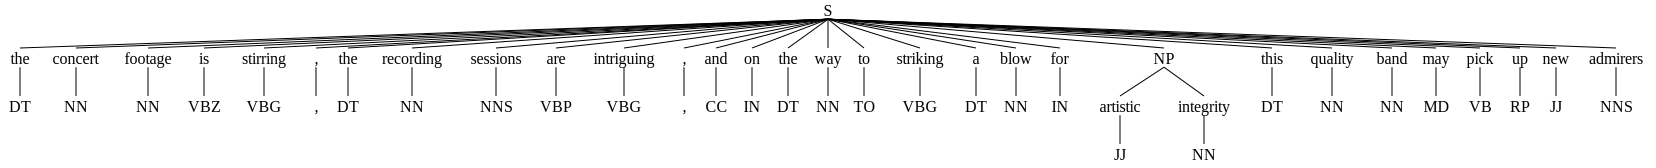

In [ ]:
svgling.draw_tree(tree)

In [ ]:
def extract_np(sentence, with_adj = True):
  noun_phrases = []
  if with_adj:
    chunk_grmr = ('''
        NP: {<DT>?<JJ>+<NN>} # NP
        ''')
  else:  
    chunk_grmr = ('''
        NP: {<DT>?<JJ>*<NN>} # NP
        ''')
  chunkParser = nltk.RegexpParser(chunk_grmr)
  tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
  tree = chunkParser.parse(tagged)
  for subtree in tree.subtrees():
    if subtree.label() == "NP":
      noun_phrases += [wrd_tag_np[0][0] for wrd_tag_np in subtree.pos()]
  
  return noun_phrases

In [ ]:
txt

"the plot is nothing but boilerplate clich s from start to finish , and the script assumes that not only would subtlety be lost on the target audience , but that it 's also too stupid to realize that they 've already seen this exact same movie a hundred times"

In [ ]:
extract_np(txt)

['this', 'exact', 'same', 'movie']

In [ ]:
noun_phrs = []
for txt in test_txt:
  noun_phrs += extract_np(txt)

In [ ]:
# set(noun_phrs)

In [ ]:
up_to = 500
for i in np.arange(up_to):
  extract_key_words(test_txt[i], stop_words, 5)
extract_np()

In [ ]:
def parse_n_draw_tree(sentence, chunk_grmr = None):
  #Define your grammar using regular expressions
  if chunk_grmr is None:
    chunk_grmr = ('''
        NP: {<DT>?<JJ>*<NN>} # NP
        ''')
  chunkParser = nltk.RegexpParser(chunk_grmr)
  tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
  tree = chunkParser.parse(tagged)
  return svgling.draw_tree(tree)


In [ ]:
def extract_adj(sentence):
  adjectives = []
  tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
  for word, pos in tagged:
    if pos == 'JJ' or pos[:2] == "VB":
      adjectives.append(word)
  return adjectives


In [ ]:
review_adj = 
extract_adj(train_txt[0])

["'s",
 'difficult',
 'conceive',
 'has',
 'reached',
 'finding',
 'amusing',
 'let',
 'funny']

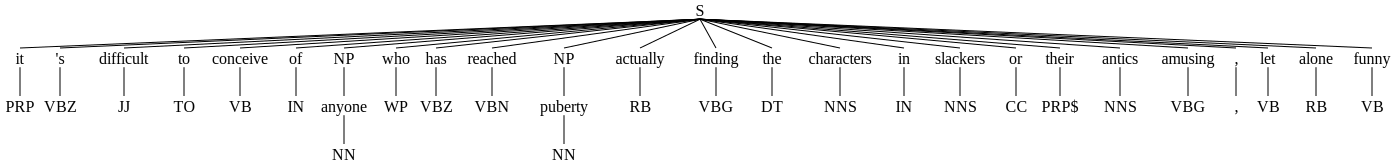

In [ ]:
parse_n_draw_tree(train_txt[1])

In [ ]:
[len(sent.split()) for sent in train_txt[:20]]

[25, 16, 17, 24, 17, 34, 6, 30, 2, 15, 5, 13, 6, 32, 14, 33, 6, 16, 16, 2]

In [ ]:
extract_key_words(train_txt[6], stop_words, 5)

Sentence of len 6 too short for key word extraction


['a', 'film', 'of', 'delicate', 'interpersonal', 'dances']

In [ ]:
key_wrds = [extract_key_words(train_txt[i], stop_words, 5) for i in range(20)]

Sentence of len 6 too short for key word extraction
Sentence of len 2 too short for key word extraction
Sentence of len 5 too short for key word extraction
Sentence of len 13 too short for key word extraction
Sentence of len 6 too short for key word extraction
Sentence of len 14 too short for key word extraction
Sentence of len 6 too short for key word extraction
Sentence of len 2 too short for key word extraction


In [ ]:
nltk.pos_tag(extract_key_words(train_txt[0], stop_words, 10))
nltk.pos_tag(nltk.word_tokenize(train_txt[0]))
for word, pos in nltk.pos_tag(nltk.word_tokenize(train_txt[0])):
  if pos[:2] == "VB":
    print(word, pos)

's VBZ
conceive VB
has VBZ
reached VBN
finding VBG
amusing VBG
let VB
funny VB


In [ ]:
from nltk.corpus import wordnet
def find_synonym(word):
  synonyms = []
  antonyms = []
  
  for syn in wordnet.synsets(word):
      for l in syn.lemmas():
          synonyms.append(l.name())
          if l.antonyms():
              antonyms.append(l.antonyms()[0].name())
    
  synonyms = set(synonyms)
  antonyms = set(antonyms)
  return synonyms, antonyms

In [ ]:
find_synonym("amusing")

({'amuse',
  'amusing',
  'amusive',
  'comic',
  'comical',
  'disport',
  'divert',
  'diverting',
  'funny',
  'laughable',
  'mirthful',
  'risible'},
 set())

In [ ]:
def similarity(word1, pos_tag1, word2, pos_tag2):
  


In [ ]:
nltk.help.upenn_tagset("VBG$")

No matching tags found.


In [ ]:
syns = wordnet.synsets("amusing")
syns[0].lemmas()

[Lemma('amuse.v.01.amuse'),
 Lemma('amuse.v.01.divert'),
 Lemma('amuse.v.01.disport')]

In [ ]:
# First, you're going to need to import wordnet:
from nltk.corpus import wordnet
  
# Then, we're going to use the term "program" to find synsets like so:

  
# An example of a synset:
print(syns[0].name())
  
# Just the word:
print(syns[0].lemmas()[0].name())
  
# Definition of that first synset:
print(syns[0].definition())
  
# Examples of the word in use in sentences:
print(syns[0].examples())

plan.n.01
plan
a series of steps to be carried out or goals to be accomplished
['they drew up a six-step plan', 'they discussed plans for a new bond issue']
